# СБОРНЫЙ ПРОЕКТ
Представим, что мы работаем в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.


Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируем ли мы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.


В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

Описание данных:
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.


Данные за 2016 год могут быть неполными.


__Шаг 1__. Откроем файл с данными и изучим общую информацию.

In [1]:
pip install --upgrade jinja2

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data = pd.read_csv('/datasets/games.csv')
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Открыв файл и изучив общую информацию видим, что:
- названия столбцов не приведены к нижнему регистру.
- есть пропуски в столбцах 'Name", "Year_of_Release", "Genre", "Critic_Score", "User_Score", "User_Score", "Rating".

Требуется предобработка данных, проверка на дубликаты и тип данных.

__Шаг 2__. Предобработка данных.

Приведем название столбцов к нижнему регистру.

In [5]:
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

__2.1.__ Обработка дубликатов и пропущенных значений.

Поиск дубликатов.

In [6]:
data.duplicated().sum()

0

Поиск неявных дубликатов.

In [7]:
dubl = data.duplicated(subset=['name', 'platform', 'year_of_release'], keep=False)
data[dubl]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E


In [8]:
data = data.drop(16230)
data = data.drop(14244)

Поиск пропущенных значений.

In [9]:
data.isna().sum()

name                  1
platform              0
year_of_release     269
genre                 1
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8577
user_score         6700
rating             6765
dtype: int64

In [1]:
pd.DataFrame(round(data.isna().mean()*100, 2)).style.background_gradient('coolwarm')

NameError: name 'pd' is not defined

- Удаляем 2 пропуска в 'name'.

In [11]:
data = data.dropna(subset=['name'])

- В 'year_of_release' пропуски можно удалить, так как их всего 2%.

In [12]:
data = data.dropna(subset=['year_of_release'])

- Удаляем 2 пропуска в 'genre'.

In [13]:
data = data.dropna(subset=['genre'])

В столбце 'critic_score' 8578 пропущенных значений, это больше чем половина от общего количества в этом столбце - 51%. Удаление или замена на медиану может повлиять на итоговый результат. Заменим на -1.

In [14]:
data['critic_score'] = data['critic_score'].fillna(-1)

В столбцах 'user_score ', 'rating' похожая ситуация, только пропусков там по 40% в каждом столбце, также заменим на -1 и 'unknown' соответственно.

In [15]:
data['user_score'] = data['user_score'].fillna(-1)

In [16]:
data['rating'] = data['rating'].fillna(-1)

In [17]:
data.isna().sum() # проверяем еще раз на наличие пропусков.

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

In [18]:
data['user_score'].unique()

array(['8', -1, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В столбце с оценкой пользователей есть уникальное значение 'tbd' - To Be Determined (будет определено), скорее всего это значит, что было собрано недостаточно оценок для формирования рейтинга. Можно сказать что рейтинга нет и в колонке вместо Nan написали 'tbd'. Заменим также на -1.

In [19]:
data['user_score'] = data['user_score'].replace('tbd', '-2')

In [20]:
data['user_score'] = data['user_score'].replace(-1, '-1')

In [21]:
data['user_score'].unique() # проверка результата.

array(['8', '-1', '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '-2', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

__2.2.__ Обработка типов данных.

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16443 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  float64
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     16443 non-null  float64
 9   user_score       16443 non-null  object 
 10  rating           16443 non-null  object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


In [23]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,-1.0,-1,-1
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1,-1


In [24]:
data['critic_score'].unique()

array([76., -1., 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

Видим, что в столбце с оценкой критиков, значения без десятых частей, заменим на целочисленный тип.

In [25]:
data['critic_score'] = data['critic_score'].astype('int')

Год выпуска также заменим на integer.

In [26]:
data['year_of_release'] = data['year_of_release'].astype('int')

Тип данных в user_score заменим на float.

In [27]:
data['user_score'] = data['user_score'].astype('float')

In [28]:
data['critic_score'].unique() # проверка.

array([76, -1, 82, 80, 89, 58, 87, 91, 61, 97, 95, 77, 88, 83, 94, 93, 85,
       86, 98, 96, 90, 84, 73, 74, 78, 92, 71, 72, 68, 62, 49, 67, 81, 66,
       56, 79, 70, 59, 64, 75, 60, 63, 69, 50, 25, 42, 44, 55, 48, 57, 29,
       47, 65, 54, 20, 53, 37, 38, 33, 52, 30, 32, 43, 45, 51, 40, 46, 39,
       34, 41, 36, 31, 27, 35, 26, 19, 28, 23, 24, 21, 17, 13])

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16443 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     16443 non-null  int64  
 9   user_score       16443 non-null  float64
 10  rating           16443 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.5+ MB


__2.3.__ Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец total_sales.

In [30]:
data['total_sales'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales' ]].sum(axis=1)

In [31]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,-1,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,-1,31.38


Вывод по предобработке данных:
- названия столбцов были приведены к нижнему регистру;
- в столбцах 'name', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating' были исправлены ошибки связанные с пропусками и заменены на значения в соотвествии с данными в столбцах.
- был найден и удален один явный дубликат.
- столбцы 'critic_score' и 'year_of_release' приведены к целочисленному типу, а 'user_score' к вещественному.
- были посчитаны суммарные пртодажи по регионам и записаны в столбец 'total_sales'.

Причины появления пропусков:
- недостоверность ифнормации или её отсутствие.
- человеческий фактор
- в столбцах с рейтингом возможен недобор необходимого числа для создания рейтинга.

__Шаг 3.__ Исследовательский анализ данных.

__3.1.__ Посмотрим, сколько игр выпускалось в разные годы.

In [32]:
data['year_of_release'].describe()

count    16443.000000
mean      2006.485921
std          5.875546
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: year_of_release, dtype: float64

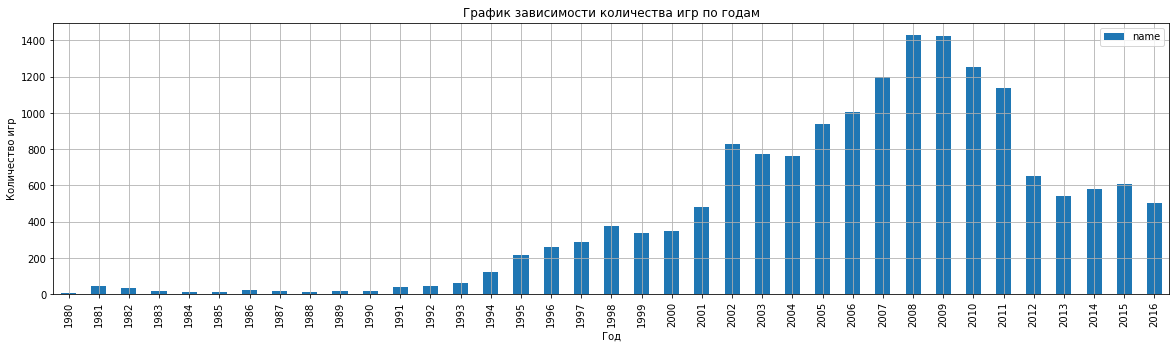

In [33]:
(
    data.pivot_table(index='year_of_release', values='name', aggfunc='count')
    .plot(kind='bar' , grid=True, figsize=(20, 5))
)
plt.title('График зависимости количества игр по годам')
plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.show()

По графику видим что с течением лет растет количество игр.
- с 1994 года активно начинает развиваться игровая индустрия.
- пик приходится на 2008 год. Связано это с тем что в этом году игры начинают выпускаться с 3Д графикой, а также с выпуском культовых серий игр, таких как GTA IV, Fallout 3, World of Warvraft  и т.д.
- после 2009 года видим спад, так как технологии уже не так активно развиваются, качество игр падает.

__3.2.__ Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам.

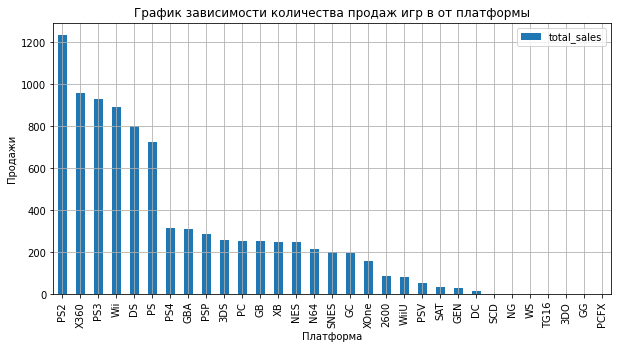

In [34]:
(
    data.pivot_table(index='platform', values='total_sales', aggfunc='sum')
    .sort_values(by='total_sales', ascending=False)
    .plot(kind='bar' , grid=True, figsize=(10, 5))
)
plt.title('График зависимости количества продаж игр в от платформы')
plt.xlabel('Платформа')
plt.ylabel('Продажи')
plt.show()

По графику видно, что у платформ PS2, XBOX 360, PS3, Wii, DS, PS больше всех продаж.

__3.3.__ Возьмем данные за соответствующий актуальный период. Для этого проанализируем жизненный цикл топ 6 консолей.

In [35]:
top_six_platforms = data.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False).reset_index().head(6)['platform'].tolist()
top_six_platforms

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

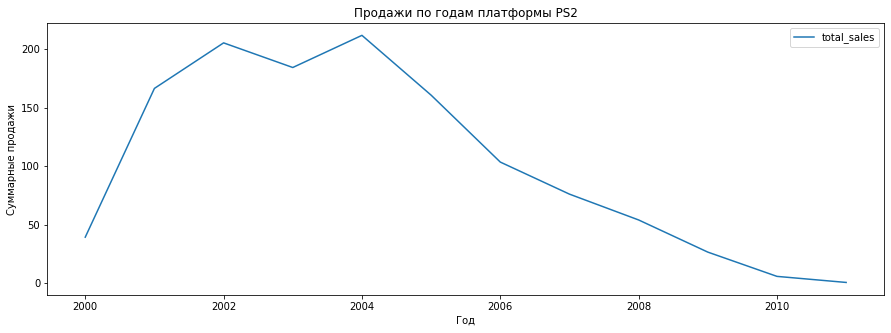

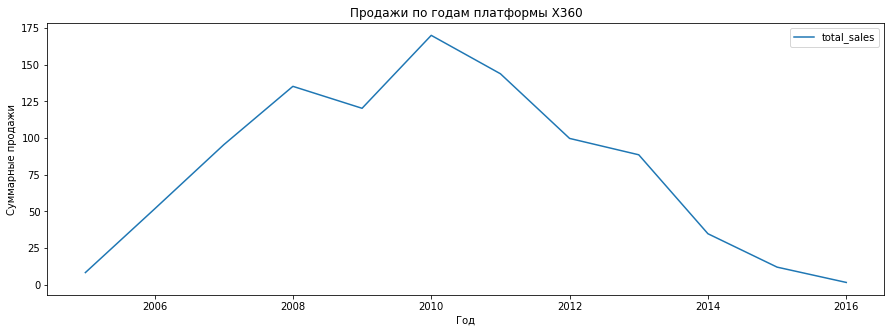

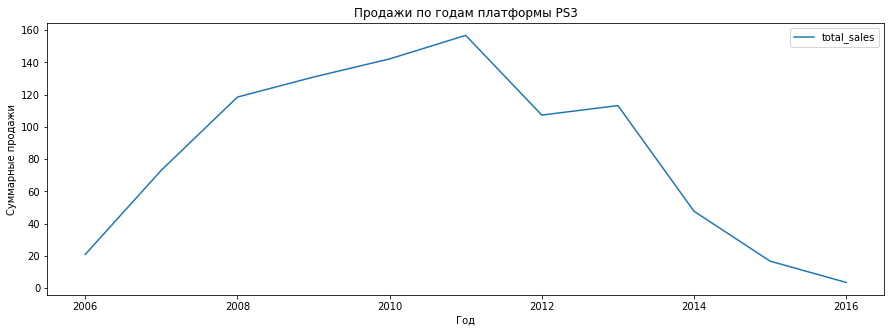

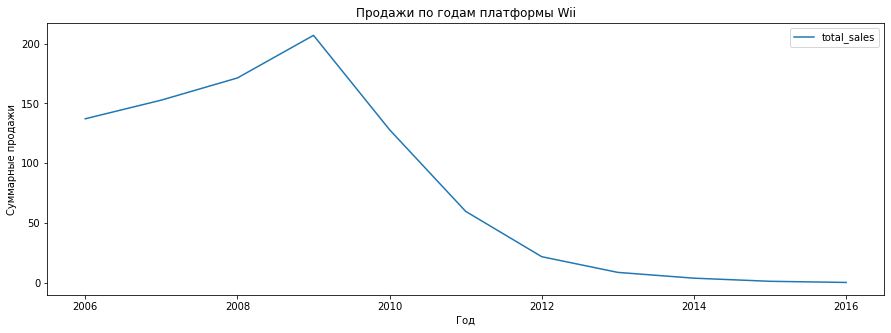

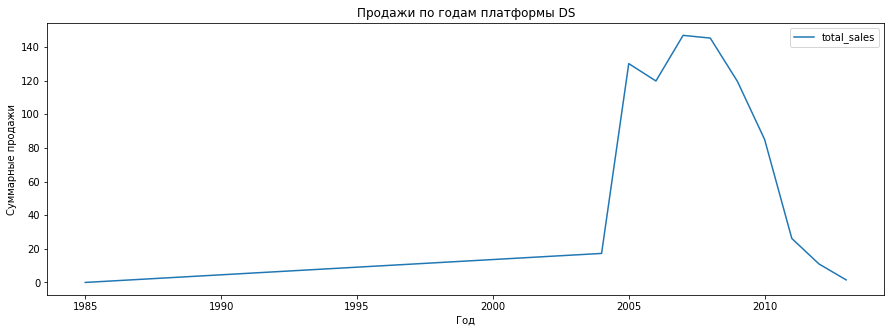

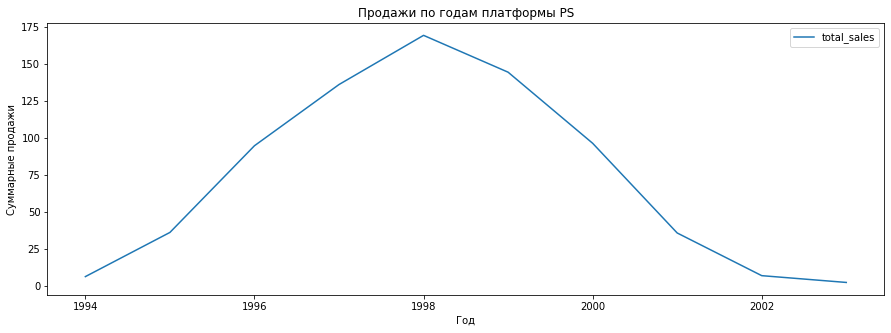

In [36]:
for name in top_six_platforms:
    (
        data.query('platform == @name and year_of_release > -1')
        .pivot_table(index='year_of_release', values='total_sales', aggfunc = 'sum')
        .sort_values(by='year_of_release', ascending = False)['total_sales']
        .plot(figsize = (15, 5))
    )
    plt.title(f'Продажи по годам платформы {name}')
    plt.xlabel('Год')
    plt.ylabel('Суммарные продажи')
    plt.legend() 
    plt.show()

На графиках видно что от начала роста до конца спада продаж проходит в среднем 10 лет.

Опеределим актуальный период:

In [37]:
time_life = data.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max'])
time_life.head()

,min,max
,year_of_release,year_of_release
platform,,
2600,1980,1989
3DO,1994,1995
3DS,2011,2016
DC,1998,2008
DS,1985,2013


In [38]:
# чтобы не терять год, прибавим единицу.
time_life['life'] = time_life['max'] - time_life['min'] + 1

Актуальным периодом можно считать первую половину жизненного цикла консолей, то есть от начала продаж до пика, включая его.

In [39]:
current_period = np.ceil(time_life['life'].median()/2).astype(int)
print('Актуальный период соствляет', current_period, 'года')

Актуальный период соствляет 4 года


Вывод:
- Жизненный цикл консолей, то есть период от начала до спада продаж составляет 10 лет.
- В ходе исследования выяснили, что актуальный период составляет 4 года.

__3.4.__ Определим какие платформы являются более или менее перспективными.

In [40]:
promising_platforms = (
    data.query('year_of_release >= 2012')
    .pivot_table(index='platform', values='total_sales', aggfunc='sum')
    .sort_values(by='total_sales', ascending=False)
    .reset_index()
    .head(10)['platform']
    .tolist()
                      )
promising_platforms

['PS4', 'PS3', 'X360', '3DS', 'XOne', 'WiiU', 'PC', 'PSV', 'Wii', 'DS']

In [41]:
promising_data = data.query('year_of_release >= 2012')
promising_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1,-1.0,-1,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,-1,-1.0,-1,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83,5.3,M,13.79


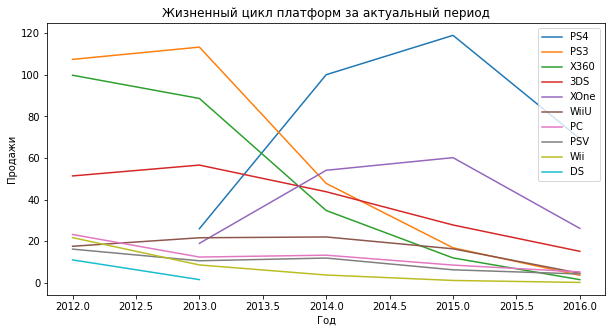

In [42]:
for name in promising_platforms:
    (
    promising_data.query('platform == @name')
    .pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'sum')
    .sort_values('year_of_release', ascending = False)['total_sales']
    .plot(kind='line', figsize = (10, 5), label=name)
    )
    plt.title('Жизненный цикл платформ за актуальный период')
    plt.xlabel('Год')
    plt.ylabel('Продажи')
    plt.legend()

Вывод:
- по графику видно, что за последние 4 года продажи у всех платформ падают, кроме PS4 и XBOX ONE. Но и у этих двух платформ с 2015 года продажи тоже начали снижаться.

__3.5.__ Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.

Text(0, 0.5, 'Продажи по платформам')

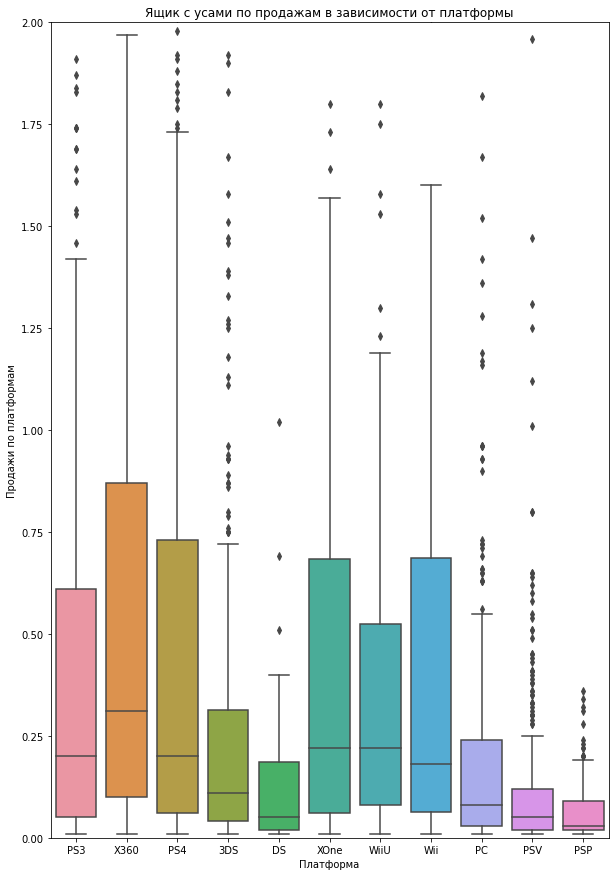

In [43]:
plt.figure(figsize=(10,15))
sns.boxplot(data=promising_data, x='platform', y='total_sales').set(ylim=(0,2))
plt.title('Ящик с усами по продажам в зависимости от платформы')
plt.xlabel('Платформа')
plt.ylabel('Продажи по платформам')

In [44]:
promising_data['total_sales'].describe()

count    2885.000000
mean        0.501393
std         1.249340
min         0.010000
25%         0.040000
50%         0.120000
75%         0.430000
max        21.050000
Name: total_sales, dtype: float64

По ящикам с усами видно:
- у всех платформ есть выбросы по продажам.
- межквартильный размах сильно подвержен разбросу.
- у всех платформ большая часть значений больше медианного.
- 10000% влияние на выбросы оказывают так называемые эксклюзивы, которые продаются гораздо лучше.

__3.6.__ Посмотрим, как влияют на продажи отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. Для анализа возьмем топ 5 платформ по продажам.

In [45]:
top_five_sale_platforms = (promising_data
    
    .pivot_table(index='platform', values='total_sales', aggfunc='sum')
    .sort_values(by='total_sales', ascending=False)
    .reset_index().head(5)['platform'].tolist()
)                      
top_five_sale_platforms

['PS4', 'PS3', 'X360', '3DS', 'XOne']

Корреляция между оценками пользователей и продажами по платформе PS4  = -0.031957110204556376


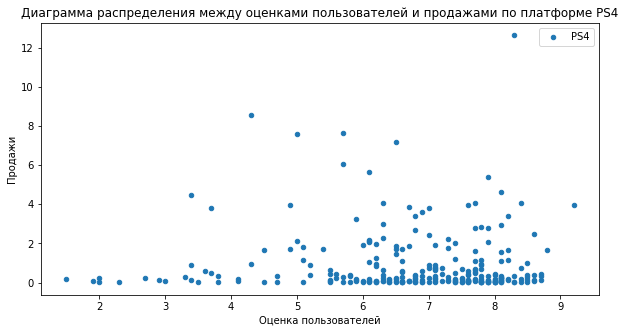

Корреляция между оценками пользователей и продажами по платформе PS3  = -0.006205767686051523


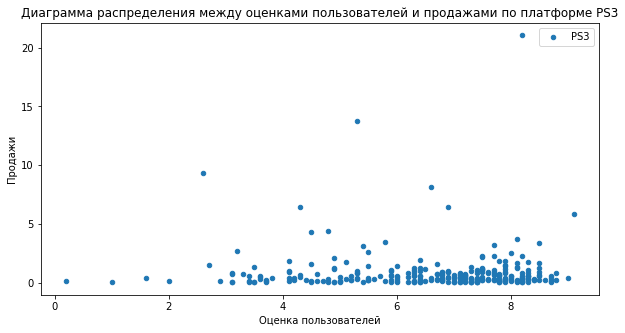

Корреляция между оценками пользователей и продажами по платформе X360  = 0.006163978646213326


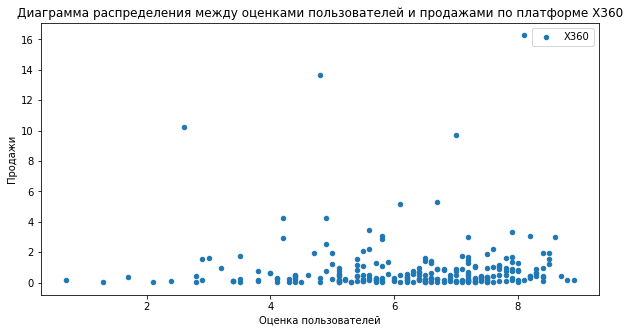

Корреляция между оценками пользователей и продажами по платформе 3DS  = 0.19758263411038599


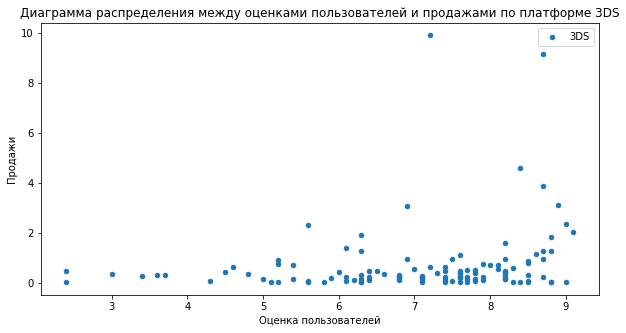

Корреляция между оценками пользователей и продажами по платформе XOne  = -0.06892505328279414


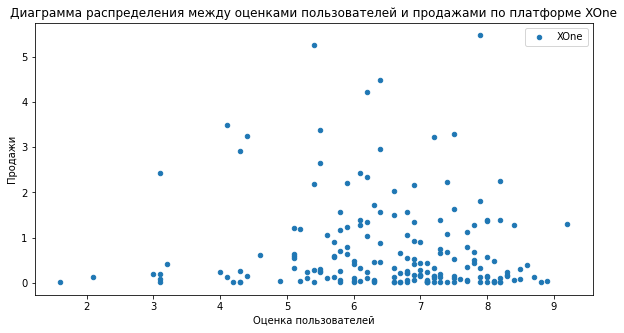

In [46]:
for name in top_five_sale_platforms:
    (
    promising_data
        .query('platform == @name and user_score > -1')
        .plot(x='user_score', 
          y='total_sales', 
          kind='scatter', 
          figsize=(10, 5)) 
    )
    plt.title(f'Диаграмма распределения между оценками пользователей и продажами по платформе {name}')
    plt.xlabel('Оценка пользователей')
    plt.ylabel('Продажи')
    plt.legend([name])
    print(f'Корреляция между оценками пользователей и продажами по платформе {name}  =', promising_data.query('platform == @name and user_score > -1')['user_score'].corr(promising_data.query('platform == @name and user_score > -1')['total_sales']))
    plt.show()

Видим слабую связь между оценками пользователей и приставками. В случае с консолью 3DS корреляция составляет почти 0.2.

Теперь построим диаграммы рассеивания для оценок критиков и продаж по платформе.

Корреляция между оценками критиков и продажами по платформе PS4  = 0.40656790206178095


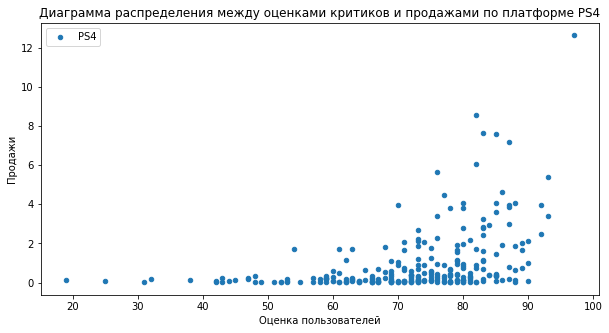

Корреляция между оценками критиков и продажами по платформе PS3  = 0.3341517575509856


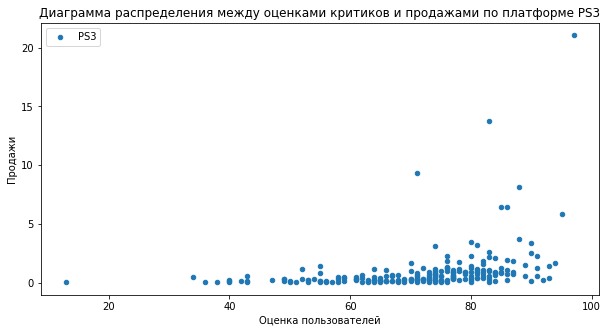

Корреляция между оценками критиков и продажами по платформе X360  = 0.3605734888507336


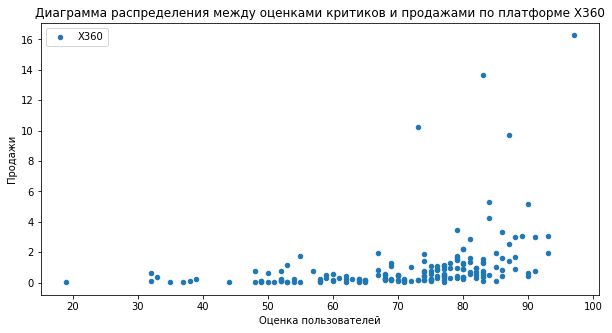

Корреляция между оценками критиков и продажами по платформе 3DS  = 0.3208028695360785


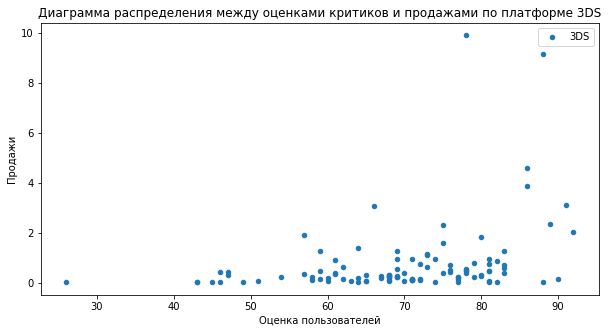

Корреляция между оценками критиков и продажами по платформе XOne  = 0.4169983280084017


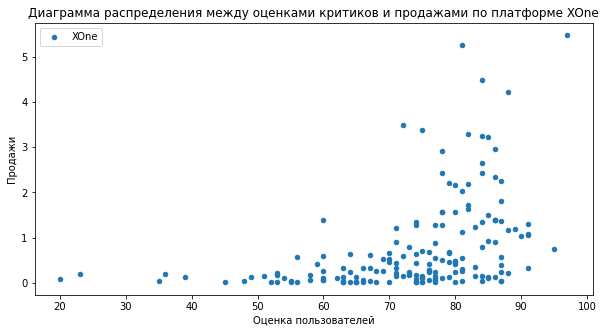

In [47]:
for name in top_five_sale_platforms:
    (
    promising_data
        .query('platform == @name and critic_score > -1')
        .plot(x='critic_score', 
          y='total_sales', 
          kind='scatter', 
          figsize=(10, 5)) 
    )
    plt.title(f'Диаграмма распределения между оценками критиков и продажами по платформе {name}')
    plt.xlabel('Оценка пользователей')
    plt.ylabel('Продажи')
    plt.legend([name])
    print(f'Корреляция между оценками критиков и продажами по платформе {name}  =', promising_data.query('platform == @name and critic_score > -1')['critic_score'].corr(promising_data.query('platform == @name and critic_score > -1')['total_sales']))
    plt.show()

Здесь видим более сильную связь. Самая высокая корреляция у XOne - почти 0.42.

Анализ графиков распределения и коэффициенты корреляции показывают нам что:
- зависимости между оценками пользователей и продажами почти нет, кроме платформы 3DS, там корреляция - 0.2.
- между оценками критиков и продажами прослеживается явная связь, корреляция лежит в диапазоне от 32 до 42.

__3.7.__ Посмотрим на общее распределение игр по жанрам. Узнаем, что можно сказать о самых прибыльных жанрах.

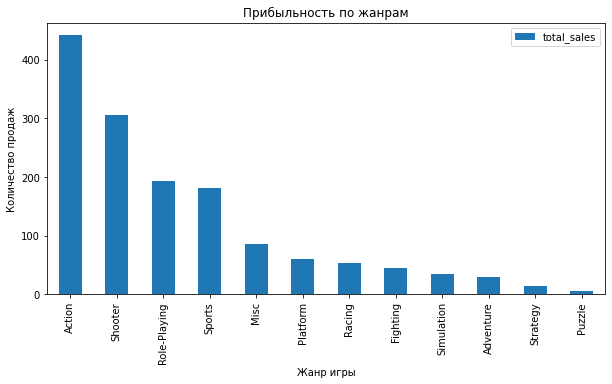

In [48]:
(
    promising_data.
    query('year_of_release >= 2012').
    pivot_table(index='genre', values='total_sales', aggfunc='sum').
    sort_values('total_sales', ascending=False).
    plot(kind='bar', y='total_sales', figsize=(10, 5))
)
plt.ylabel('Количество продаж')
plt.xlabel('Жанр игры')
plt.title('Прибыльность по жанрам')
plt.show()

Text(0, 0.5, 'Продажи по жанрам')

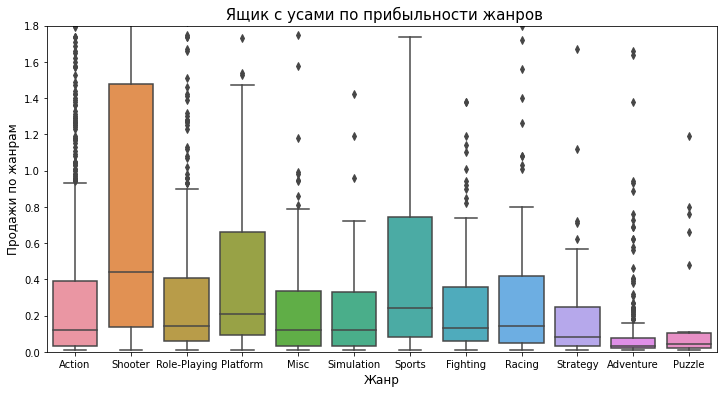

In [49]:
plt.figure(figsize=(12,6))
ax = sns.boxplot(data=promising_data, x='genre', y='total_sales')
ax.set(ylim=(0,1.8))
plt.title(' Ящик с усами по прибыльности жанров', fontsize=15)
plt.xlabel('Жанр', fontsize=12)
plt.ylabel('Продажи по жанрам',fontsize=12)

In [50]:
(
 promising_data
 .pivot_table(index='genre', values='total_sales', aggfunc='median')
 .sort_values('total_sales', ascending=False)
)

,total_sales
genre,
Shooter,0.440
Sports,0.240
Platform,0.210
Role-Playing,0.140
Racing,0.140
Fighting,0.130
Action,0.120
Misc,0.120
Simulation,0.120


По графику видно что самыми продаваемыми были игры в жанре action, следом идут шутеры, самый скромный это жанр puzzle.

Однако игры в жанре action приносят прибыль в основном с эксклюзивов, которые выпускаются отнюдь не регулярно. Более стабильные игры это шутеры и спортивные. У шутеров самая большая медиана.

Итоги исследовательского анализа:
- с течением лет растет количество игр.
- с 1994 года активно начинает развиваться игровая индустрия.
- пик приходится на 2008 год. Связано это с тем что в этом году игры начинают выпускаться с 3Д графикой, а также с выпуском культовых серий игр, таких как GTA IV, Fallout 3, World of Warvraft  и т.д.
- после 2009 года видим спад, так как технологии уже не так активно развиваются, качество игр падает.

- У платформ PS2, XBOX 360, PS3, Wii, DS, PS больше всех продаж.
- Жизненный цикл консолей, то есть период от начала до спада продаж составляет 10 лет.
- В ходе исследования выяснили, что актуальный период составляет 4 года.

- за последние 4 года продажи у всех платформ падают, кроме PS4 и XBOX ONE. Но и у этих двух платформ с 2015 года продажи тоже начали снижаться.

- у всех платформ есть выбросы по продажам.
- межквартильный размах сильно подвержен разбросу.

Анализ графиков распределения и коэффициенты корреляции показывают нам что:
- зависимости между оценками пользователей и продажами почти нет, кроме платформы 3DS, там корреляция - 0.2.
- между оценками критиков и продажами прослеживается явная связь, корреляция лежит в диапазоне от 32 до 42.

Самыми продаваемыми были игры в жанре action, следом идут шутеры, самый скромный это жанр puzzle.
Однако игры в жанре action приносят прибыль в основном с эксклюзивов, которые выпускаются отнюдь не регулярно. Более стабильные игры это шутеры и спортивные. У шутеров самая большая медиана.

__Шаг 4.__ Составим портрет пользователя каждого региона.

__4.1.__ Самые популярные платформы (топ-5).

In [51]:
top_na = promising_data.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).head()
top_eu = promising_data.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).head()
top_jp = promising_data.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).head()

In [52]:
top_na

,na_sales
platform,
X360,140.05
PS4,108.74
PS3,103.38
XOne,93.12
3DS,55.31


<AxesSubplot:title={'center':'Доля платформы в продаже в Северной Америке'}, ylabel='na_sales'>

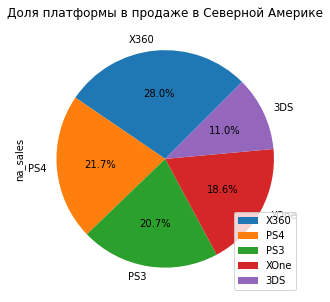

In [53]:
top_na.plot.pie(
    y='na_sales',
    figsize=(5, 5),
    title='Доля платформы в продаже в Северной Америке',
    autopct='%1.1f%%',
    startangle=45)

In [54]:
top_eu

,eu_sales
platform,
PS4,141.09
PS3,106.85
X360,74.52
XOne,51.59
3DS,42.64


<AxesSubplot:title={'center':'Доля платформы в продаже в Европе'}, ylabel='eu_sales'>

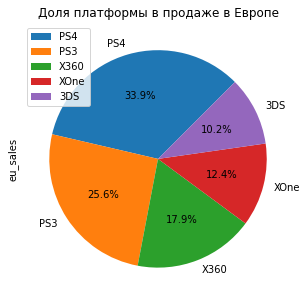

In [55]:
top_eu.plot.pie(
    y='eu_sales',
    figsize=(5, 5),
    title='Доля платформы в продаже в Европе',
    autopct='%1.1f%%',
    startangle=45)

In [56]:
top_jp

,jp_sales
platform,
3DS,87.79
PS3,35.29
PSV,21.04
PS4,15.96
WiiU,13.01


<AxesSubplot:title={'center':'Доля платформы в продаже в Японии'}, ylabel='jp_sales'>

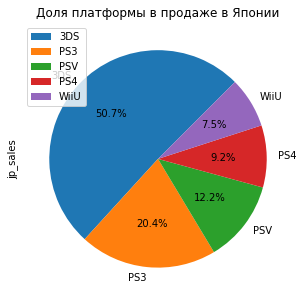

In [57]:
top_jp.plot.pie(
    y='jp_sales',
    figsize=(5, 5),
    title='Доля платформы в продаже в Японии',
    autopct='%1.1f%%',
    startangle=45)

- В Северной Америке наибольшим спросом пользуется XBOX 360, наименее полулярна 3DS.
- В Европе же наоборот, больше пользуются PS4, 3DS также неактуальна.
- В Японии 3DS занимает больше чем половину рынка, следом PS3

__4.2.__ Самые популярные жанры (топ-5).

In [58]:
na_genre = promising_data.groupby('genre').agg({'na_sales': 'sum'}).sort_values(by='na_sales', ascending=False).head()
eu_genre = promising_data.groupby('genre').agg({'eu_sales': 'sum'}).sort_values(by='eu_sales', ascending=False).head()
jp_genre = promising_data.groupby('genre').agg({'jp_sales': 'sum'}).sort_values(by='jp_sales', ascending=False).head()

<function matplotlib.pyplot.show(close=None, block=None)>

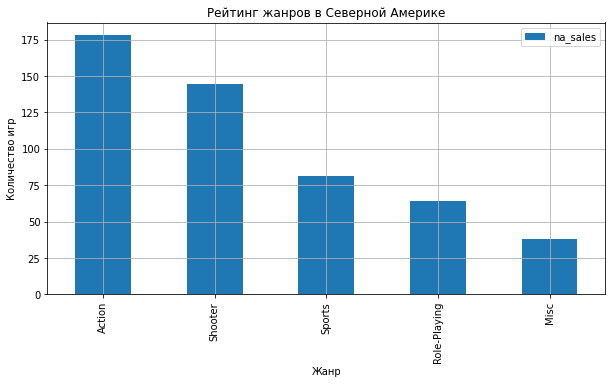

In [59]:
na_genre.plot(kind='bar', grid=True, figsize=(10,5))
plt.title('Рейтинг жанров в Северной Америке')
plt.xlabel('Жанр')
plt.ylabel('Количество игр')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

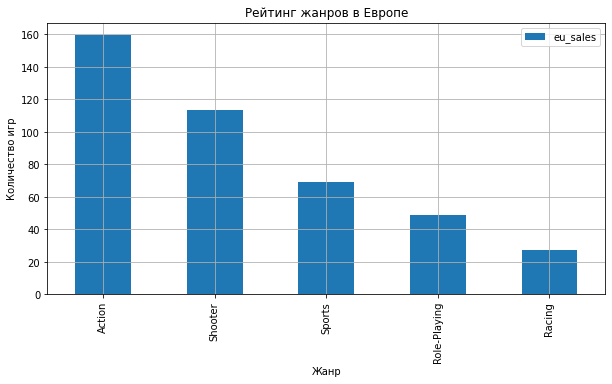

In [60]:
eu_genre.plot(kind='bar', grid=True, figsize=(10,5))
plt.title('Рейтинг жанров в Европе')
plt.xlabel('Жанр')
plt.ylabel('Количество игр')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

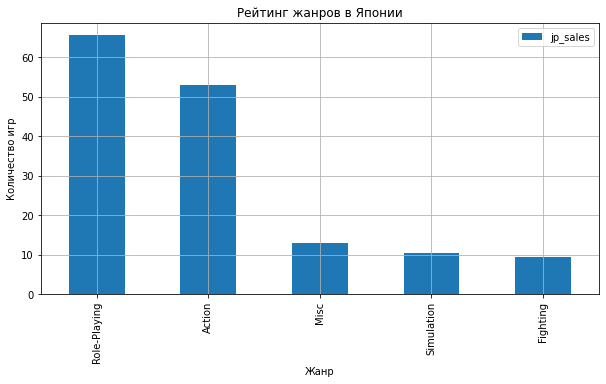

In [61]:
jp_genre.plot(kind='bar', grid=True, figsize=(10,5))
plt.title('Рейтинг жанров в Японии')
plt.xlabel('Жанр')
plt.ylabel('Количество игр')
plt.show

- В Северной Америке в основном играют в шутеры и экшены.
- В Европе аналогично как и в Америке.
- В Японии же людям больше по вкусу ролевые игры.

__4.3.__ Узнаем влияет ли рейтинг ESRB на продажи в отдельном регионе.

In [62]:
na_esrb = promising_data.groupby('rating').agg({'na_sales': 'sum'}).sort_values(by='na_sales', ascending=False).head()
eu_esrb = promising_data.groupby('rating').agg({'eu_sales': 'sum'}).sort_values(by='eu_sales', ascending=False).head()
jp_esrb = promising_data.groupby('rating').agg({'jp_sales': 'sum'}).sort_values(by='jp_sales', ascending=False).head()

<function matplotlib.pyplot.show(close=None, block=None)>

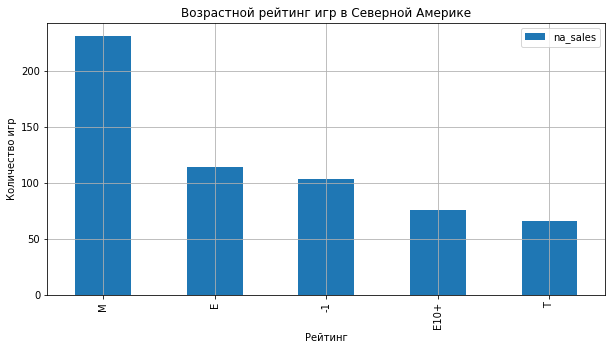

In [63]:
na_esrb.plot(kind='bar', grid=True, figsize=(10,5))
plt.title('Возрастной рейтинг игр в Северной Америке')
plt.xlabel('Рейтинг')
plt.ylabel('Количество игр')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

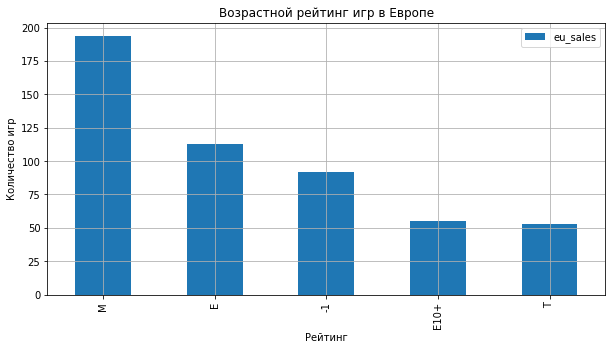

In [64]:
eu_esrb.plot(kind='bar', grid=True, figsize=(10,5))
plt.title('Возрастной рейтинг игр в Европе')
plt.xlabel('Рейтинг')
plt.ylabel('Количество игр')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

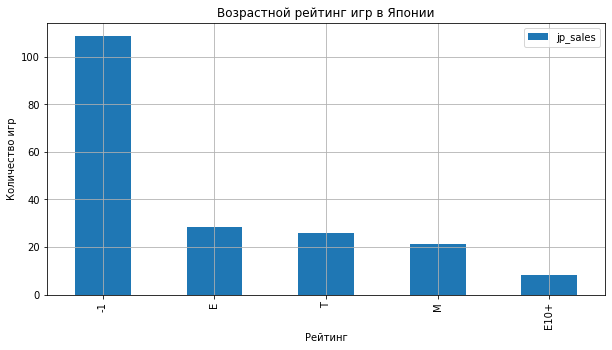

In [65]:
jp_esrb.plot(kind='bar', grid=True, figsize=(10,5))
plt.title('Возрастной рейтинг игр в Японии')
plt.xlabel('Рейтинг')
plt.ylabel('Количество игр')
plt.show

- В Северной Америке статистика возрастного рейтинга игр одинаковая: больше всего игр в категории 'М', меньше всего 'Т'.
- В Японии же игр с неопределенным рейтингом больше всего. Скорее всего эти игры ожидают своей категории.

Портреты пользователей в каждом регионе:
- Североамериканец в основном играет в шутеры и action-игры с рейтингом 'Mature' на XBOX 360.
- В Европе большинство играет также в шутеры и action-игры с рейтингом 'не младже 17 лет', но уже на PS4 или PS3.
- Японцы больше любят играть в ролевые игры с неопределенным рейтингом на 3DS. 

__Шаг 5.__ Проверим гипотезы

__5.1__ Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

- Ho - Средние пользовательские рейтинги платформ Xbox One и PC равны.
- H1 - Средние пользовательские рейтинги платформ Xbox One и PC не равны.

In [66]:
xbox_one = promising_data.query("platform == 'XOne' and user_score > 0")['user_score']
pc = promising_data.query("platform == 'PC' and user_score > 0")['user_score']
results = st.ttest_ind(xbox_one, pc, alternative='two-sided')
alpha = 0.05
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.5535080500643661
Не получилось отвергнуть нулевую гипотезу


Вывод: по результатам теста не получилось отвергнуть нулевую гипотезу, есть основания полагать, что средние пользовательские рейтинги платформ Xbox One и PC равны.

__5.2__ Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

- Ho - Средние пользовательские рейтинги жанров Action и Sports равны.
- H1 - Средние пользовательские рейтинги жанров Action и Sports не равны.

In [67]:
act = promising_data.query('genre == "Action" and user_score > 0')['user_score']
sport = promising_data.query('genre == "Sports" and user_score > 0')['user_score']
results = st.ttest_ind(act, sport, alternative='two-sided')
alpha = 0.05
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 4.8045233804629176e-26
Отвергаем нулевую гипотезу


Вывод: по результатам теста отвергаем нулевую гипотезу, есть основания полагать, что средние пользовательские рейтинги жанров Action и Sports разные.

__Шаг 6.__ Общий вывод:

__В ходе предобработки данных было сделано следующее:__
- названия столбцов были приведены к нижнему регистру;
- в столбцах 'name', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating' были исправлены ошибки связанные с пропусками и заменены на значения в соотвествии с данными в столбцах.
- был найден удален один явный дубликат.
- столбцы 'critic_score' и 'year_of_release' приведены к целочисленному типу, а 'user_score' к вещественному.
- были посчитаны суммарные пртодажи по регионам и записаны в столбец 'total_sales'.

__Исследовательский анализ показал:__
- с течением лет растет количество игр.
- с 1994 года активно начинает развиваться игровая индустрия.
- пик приходится на 2008 год. Связано это с тем что в этом году игры начинают выпускаться с 3Д графикой, а также с выпуском культовых серий игр, таких как GTA IV, Fallout 3, World of Warvraft  и т.д.
- после 2009 года видим спад, так как технологии уже не так активно развиваются, качество игр падает.

- У платформ PS2, XBOX 360, PS3, Wii, DS, PS больше всех продаж.
- Жизненный цикл консолей, то есть период от начала до спада продаж составляет 10 лет.
- В ходе исследования выяснили, что актуальный период составляет 4 года.

- за последние 4 года продажи у всех платформ падают, кроме PS4 и XBOX ONE. Но и у этих двух платформ с 2015 года продажи тоже начали снижаться.

- у всех платформ есть выбросы по продажам.
- межквартильный размах сильно подвержен разбросу.

Анализ графиков распределения и коэффициенты корреляции показывают нам что:
- зависимости между оценками пользователей и продажами почти нет, кроме платформы 3DS, там корреляция - 0.2.
- между оценками критиков и продажами прослеживается явная связь, корреляция лежит в диапазоне от 32 до 42.

Самыми продаваемыми были игры в жанре action, следом идут шутеры, самый скромный это жанр puzzle.
Однако игры в жанре action приносят прибыль в основном с эксклюзивов, которые выпускаются отнюдь не регулярно. Более стабильные игры это шутеры и спортивные. У шутеров самая большая медиана.

__Портреты пользователей в каждом регионе:__
- Североамериканец в основном играет в шутеры и action-игры с рейтингом 'Mature' на XBOX 360.
- В Европе большинство играет также в шутеры и action-игры с рейтингом 'не младже 17 лет', но уже на PS4 или PS3.
- Японцы больше любят играть в ролевые игры с неопределенным рейтингом на 3DS. 

__Проверка гипотез:__
- средние пользовательские рейтинги платформ Xbox One и PC равны.
- средние пользовательские рейтинги жанров Action и Sports разные.

__Рекомендации:__ 
 Для рекламной кампании на 2017 год стоит обратить внимание на платформы PS4 и XBOX ONE для Северной Америке и Европы, а также на 3DS для Японии. Продвижение следует сделать для игр в жанре Action, Sports, Shooter c рейтингом 'Mature' и 'Everyone'.